# Image Prediction Models

This notebook contains the models that we will use to predict stocks using images.

Here we are using two models:
1. CNN2d
2. ResNet50

Importing relevant libraries

In [ ]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from keras import layers
from keras.applications import ResNet50
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.callbacks import EarlyStopping
from keras.models import Model, Sequential
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


In [106]:
# Define the file path for the image.
image_path = "/home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/data/FIAP_PI/BBAS3.SA/imagens/teste/comprar/2019-04-29_1.png"

# Open the image using the PIL library.
image = Image.open(image_path)

# Get the image dimensions (width, height).
width, height = image.size

# Create a tuple with dimensions swapped (height, width) if needed.
img_size = (height, width)

# Print out the image dimensions.
print(f"Image size: {width}x{height} pixels")

Image size: 100x333 pixels


Defining training parameters.

In [107]:
EPOCHS = 200
BATCH_SIZE = 32
LEARNING_RATE = 1e-6
LEARNING_RATE_RESNET = 1e-4
PATIENCE = 10

#### Data Loading and Preprocessing

Loading image data.

In [ ]:
# Set the base data directory, stock symbols, and target image size.
data_dir = '/home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/data/FIAP_PI'
stocks = ['BBAS3.SA', 'CSNA3.SA', 'PETR4.SA', 'VALE3.SA']
img_size = (224, 224)

# Define a function to load an image dataset for a given stock.
def load_dataset(stock, subset, data_type, seed=123):
    # Build the path to the images directory.
    stock_image_dir = os.path.join(data_dir, stock, "imagens", data_type)
    
    # Load images from the directory into a TensorFlow dataset.
    return tf.keras.utils.image_dataset_from_directory(
        stock_image_dir,
        validation_split=0.2 if subset != "test" else None,
        subset=subset if subset != "test" else None,
        seed=seed,
        image_size=img_size,
        batch_size=BATCH_SIZE,
        label_mode="categorical"
    )

# Define a preprocessing function to normalize images for ResNet50.
def resnet_preprocess(images, labels):
    images = tf.cast(images, tf.float32)
    images = preprocess_input(images)
    return images, labels

train_dfs, val_dfs, test_dfs = [], [], []

# Loop through each stock to load and combine their datasets.
for stock in stocks:
    print(f'Carregando dados para {stock}...')
    
    print("Dados de Treino")
    train_df = load_dataset(stock, "training", data_type="treino")
    val_df = load_dataset(stock, "validation", data_type="treino")
    
    print("Dados de Teste")
    test_df = load_dataset(stock, "test", data_type="teste")

    train_dfs.append(train_df)
    val_dfs.append(val_df)
    test_dfs.append(test_df)
    

Carregando dados para BBAS3.SA...
Dados de Treino
Found 4735 files belonging to 2 classes.
Using 3788 files for training.
Found 4735 files belonging to 2 classes.
Using 947 files for validation.
Dados de Teste
Found 1185 files belonging to 2 classes.
Carregando dados para CSNA3.SA...
Dados de Treino
Found 4743 files belonging to 2 classes.
Using 3795 files for training.
Found 4743 files belonging to 2 classes.
Using 948 files for validation.
Dados de Teste
Found 1186 files belonging to 2 classes.
Carregando dados para PETR4.SA...
Dados de Treino
Found 4808 files belonging to 2 classes.
Using 3847 files for training.
Found 4808 files belonging to 2 classes.
Using 961 files for validation.
Dados de Teste
Found 1203 files belonging to 2 classes.
Carregando dados para VALE3.SA...
Dados de Treino
Found 3268 files belonging to 2 classes.
Using 2615 files for training.
Found 3268 files belonging to 2 classes.
Using 653 files for validation.
Dados de Teste
Found 1203 files belonging to 2 class

Loading time series data.

In [ ]:
test_time_series_dfs = []

# Load training and testing data for each stock
for stock in stocks:
    stock_dir = os.path.join(data_dir, stock)
    test_stock_df = pd.read_csv(f"{stock_dir}/teste.csv", index_col=0)

    test_stock_df.iloc[:, 3] = test_stock_df.iloc[:, 3].replace(-1, 0) 

    # Append DataFrames to respective lists
    test_time_series_dfs.append(test_stock_df)

Visualizing shapes and class names.

In [109]:
for images, labels in train_dfs[0].take(1):
    print(images.shape, labels.shape)

class_names = train_dfs[0].class_names
print(class_names)

(32, 224, 224, 3) (32, 2)
['comprar', 'vender']


Visualizing sample images.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


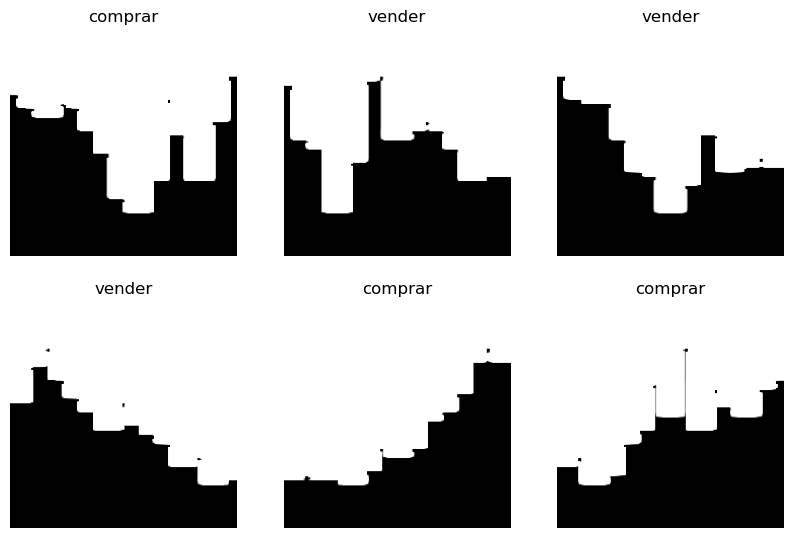

In [110]:
plt.figure(figsize=(10, 10))
for images, labels in train_dfs[0].take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[tf.argmax(labels[i]).numpy()])
        plt.axis("off")
plt.show()

Preprocessing the images


In [111]:
for i in range(len(stocks)):
    # Map the preprocessing function to the datasets.
    train_dfs[i] = train_dfs[i].map(resnet_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    val_dfs[i]   = val_dfs[i].map(resnet_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    test_dfs[i]  = test_dfs[i].map(resnet_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

    # Prefetch the datasets to enhance performance during training and evaluation.
    train_dfs[i] = train_dfs[i].prefetch(tf.data.AUTOTUNE)
    val_dfs[i]   = val_dfs[i].prefetch(tf.data.AUTOTUNE)
    test_dfs[i]  = test_dfs[i].prefetch(tf.data.AUTOTUNE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].


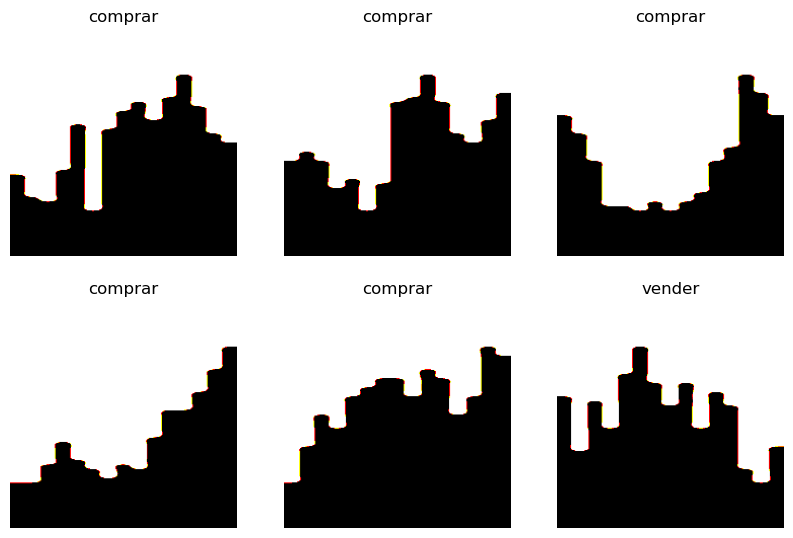

In [112]:
plt.figure(figsize=(10, 10))
for images, labels in train_dfs[0].take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[tf.argmax(labels[i]).numpy()])
        plt.axis("off")
plt.show()

Define history ploting method.

In [113]:
def plot_training_history(history):
    """
    Plots training & validation accuracy and loss from a Keras model history.

    Parameters:
    history : keras.callbacks.History
        The history object returned by model.fit()
    """
    history_dict = history.history

    # Create a figure with two subplots
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history_dict['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    plt.grid()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history_dict['loss'], label='Training Loss', color='blue')
    plt.plot(history_dict['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()
    plt.grid()

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

In [114]:
def plot_metrics(y_true, y_pred):
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Print evaluation results
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1: {f1:.2f}")
    print("Confusion matrix:")

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

In [115]:
def define_early_stopping():
    # Define EarlyStopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',   # Monitor validation loss
        patience=PATIENCE,          # Stop training if val_loss doesn't improve for PATIENCE
        restore_best_weights=True,  # Restore the best model weights after stopping
        verbose=1
    )
    
    return early_stopping

Defines backtesting and evaluation metrics.

In [146]:
def backtest_strategy_np(prices, predictions, initial_cash=10000, price_index=0):
    cash = initial_cash
    position = 0
    portfolio_values = []
    
    for i in range(len(prices)):
        price = prices[i]
        signal = int(predictions[i])
        # print(f"PRICE: {price}, SIGNAL: {signal}")
        
        if signal == 1 and position == 0:
            shares_to_buy = int(cash // price)
            if shares_to_buy > 0:
                # print("bought\n")
                position = shares_to_buy
                cash -= position * price

        elif signal == 0 and position > 0:
            # print("sold\n")
            cash += position * price
            position = 0
        
        portfolio_value = cash + position * price
        portfolio_values.append(portfolio_value)
    
    # Final liquidation if still holding a position
    if position > 0:
        if prices.ndim > 1:
            final_price = float(prices[-1, price_index])
        else:
            final_price = float(prices[-1])
        cash += position * final_price
        position = 0
    
    final_value = cash
    return portfolio_values, final_value


In [154]:
def results(models):
    for stock, model, test_ds, test_df in zip(stocks, models, test_dfs, test_time_series_dfs):
        print(f"Test results for stock: {stock}")
        print(f"Model: {model.__class__}")
        # Obtain predictions and true labels
        y_true = []
        y_pred = []
        predicted_signals = []

        for images, labels in test_ds:
            predictions = model.predict(images, verbose=0)
            y_true.extend(np.argmax(labels.numpy(), axis=1))
            y_pred.extend(np.argmax(predictions, axis=1))

        prices = test_df.iloc[:,2].to_numpy()

        plot_metrics(y_true, y_pred)

        print(f"Backtesting for {stock}")
        portfolio_values, final_value = backtest_strategy_np(prices, y_pred)
        
        print(f"Final portfolio value for {stock}: R${final_value:.2f}")

        # Create a dual Y-axis plot
        fig, ax1 = plt.subplots(figsize=(10, 5))
        ax2 = ax1.twinx()  # Create a second y-axis sharing the same x-axis

        # Plot stock prices on the left y-axis
        ax1.plot(prices, label='Stock Price', color='blue', linewidth=2)
        ax1.set_xlabel('Time Step')
        ax1.set_ylabel('Stock Price', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')

        # Plot portfolio values on the right y-axis
        ax2.plot(portfolio_values, label='Portfolio Value', color='orange', linestyle='--', linewidth=2)
        ax2.set_ylabel('Portfolio Value', color='orange')
        ax2.tick_params(axis='y', labelcolor='orange')

        # Title and legend
        plt.title(f'Stock Price and Portfolio Value Over Time for {stock}')
        fig.tight_layout()
        fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
        plt.show()
        print()


## Models

### CNN2d  Model.

In [116]:
def cnn2d_model():
    # Define the CNN model
    model = Sequential([
        layers.Rescaling(1./255, input_shape=(img_size[0], img_size[1], 3)),    # Normalize input images
        layers.Conv2D(16, 3, padding='same', activation='relu'),                # Conv layer with 16 filters
        layers.MaxPooling2D(),                                                  # Reduce spatial dimensions
        layers.Conv2D(32, 3, padding='same', activation='relu'),                # Conv layer with 32 filters
        layers.MaxPooling2D(),                                                  # Reduce spatial dimensions
        layers.Conv2D(64, 3, padding='same', activation='relu'),                # Conv layer with 64 filters
        layers.MaxPooling2D(),                                                  # Reduce spatial dimensions
        layers.Flatten(),                                                       # Flatten feature maps into 1D vector
        layers.Dense(32, activation='relu'),                                    # Dense layer with 32 units
        layers.Dense(2)                                                         # Output layer: one neuron per class (logits)
    ])

    # Compile the model with Adam optimizer and categorical crossentropy loss (using logits)
    model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    return model

/home/mark/anaconda3/envs/sandbox/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │     1,605,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,629,314 (6.22 MB)

 Trainable params: 1,629,314 (6.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200


119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8327 - loss: 0.3511 - val_accuracy: 0.8838 - val_loss: 0.2551
Epoch 2/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8867 - loss: 0.2606 - val_accuracy: 0.8712 - val_loss: 0.2947
Epoch 3/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8961 - loss: 0.2420 - val_accuracy: 0.8754 - val_loss: 0.2743
Epoch 4/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9003 - loss: 0.2306 - val_accuracy: 0.8765 - val_loss: 0.2719
Epoch 5/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9004 - loss: 0.2256 - val_accuracy: 0.8849 - val_loss: 0.2736
Epoch 6/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9084 - loss: 0.2129 - val_accuracy: 0.8754 - val_loss: 0.3511
Epoch 7/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9206 - loss: 0.1973 - val_accuracy: 0.8617 - val_loss: 0.3525
Epoch 8/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9408 - loss: 0.1501 - val_accuracy: 0.862

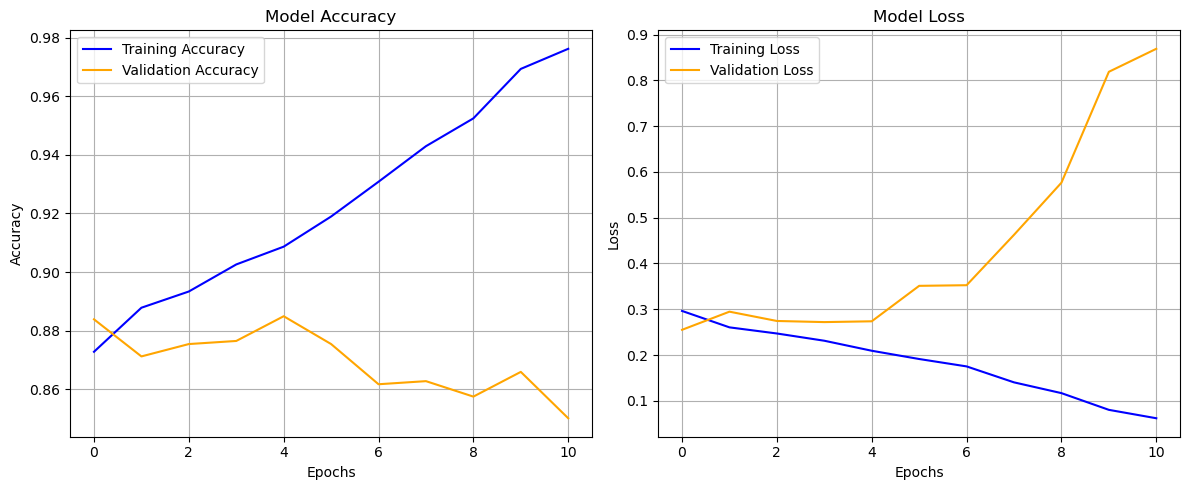

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │     1,605,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,629,314 (6.22 MB)

 Trainable params: 1,629,314 (6.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8083 - loss: 0.3825 - val_accuracy: 0.8797 - val_loss: 0.2623
Epoch 2/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9009 - loss: 0.2547 - val_accuracy: 0.8692 - val_loss: 0.3232
Epoch 3/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8934 - loss: 0.2466 - val_accuracy: 0.8703 - val_loss: 0.2977
Epoch 4/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8941 - loss: 0.2321 - val_accuracy: 0.8608 - val_loss: 0.2956
Epoch 5/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9034 - loss: 0.2246 - val_accuracy: 0.8671 - val_loss: 0.3350
Epoch 6/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9217 - loss: 0.1906 - val_accuracy: 0.8755 - val_loss: 0.2948
Epoch 7/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9320 - loss: 0.1707 - val_accuracy: 0.8650 - val_loss: 0.3325
Epoch 8/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9408 - loss: 0.1372 - val_acc

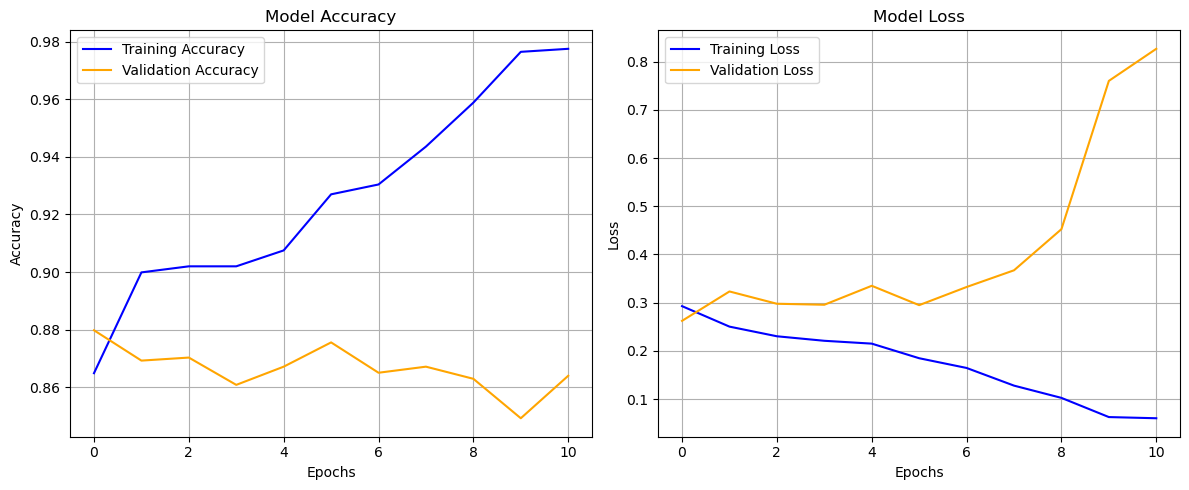

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │     1,605,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,629,314 (6.22 MB)

 Trainable params: 1,629,314 (6.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8206 - loss: 0.3787

2025-02-27 12:54:58.247797: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_2', 36 bytes spill stores, 36 bytes spill loads



121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8211 - loss: 0.3779 - val_accuracy: 0.8959 - val_loss: 0.2369
Epoch 2/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8942 - loss: 0.2510 - val_accuracy: 0.8855 - val_loss: 0.2684
Epoch 3/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8967 - loss: 0.2351 - val_accuracy: 0.8887 - val_loss: 0.2611
Epoch 4/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9062 - loss: 0.2172 - val_accuracy: 0.8783 - val_loss: 0.2789
Epoch 5/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9110 - loss: 0.2141 - val_accuracy: 0.8762 - val_loss: 0.3041
Epoch 6/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9229 - loss: 0.1851 - val_accuracy: 0.8772 - val_loss: 0.3641
Epoch 7/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9312 - loss: 0.1743 - val_accuracy: 0.8699 - val_loss: 0.4070
Epoch 8/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9353 - loss: 0.1608 - val_accuracy: 0.881

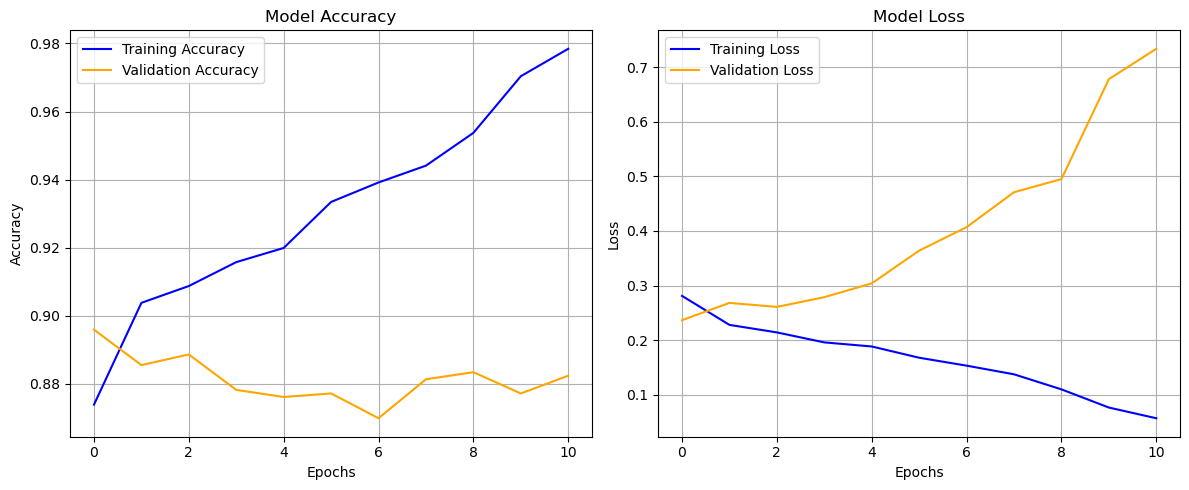

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │     1,605,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,629,314 (6.22 MB)

 Trainable params: 1,629,314 (6.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8627 - loss: 0.4057 - val_accuracy: 0.8760 - val_loss: 0.2795
Epoch 2/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9100 - loss: 0.1916 - val_accuracy: 0.8989 - val_loss: 0.2309
Epoch 3/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9215 - loss: 0.1829 - val_accuracy: 0.8882 - val_loss: 0.2461
Epoch 4/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9321 - loss: 0.1614 - val_accuracy: 0.8806 - val_loss: 0.2720
Epoch 5/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9373 - loss: 0.1406 - val_accuracy: 0.8821 - val_loss: 0.3138
Epoch 6/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9403 - loss: 0.1294 - val_accuracy: 0.8622 - val_loss: 0.3527
Epoch 7/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9604 - loss: 0.1059 - val_accuracy: 0.8637 - val_loss: 0.4081
Epoch 8/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9712 - loss: 0.0736 - val_accuracy: 0.8652 - 

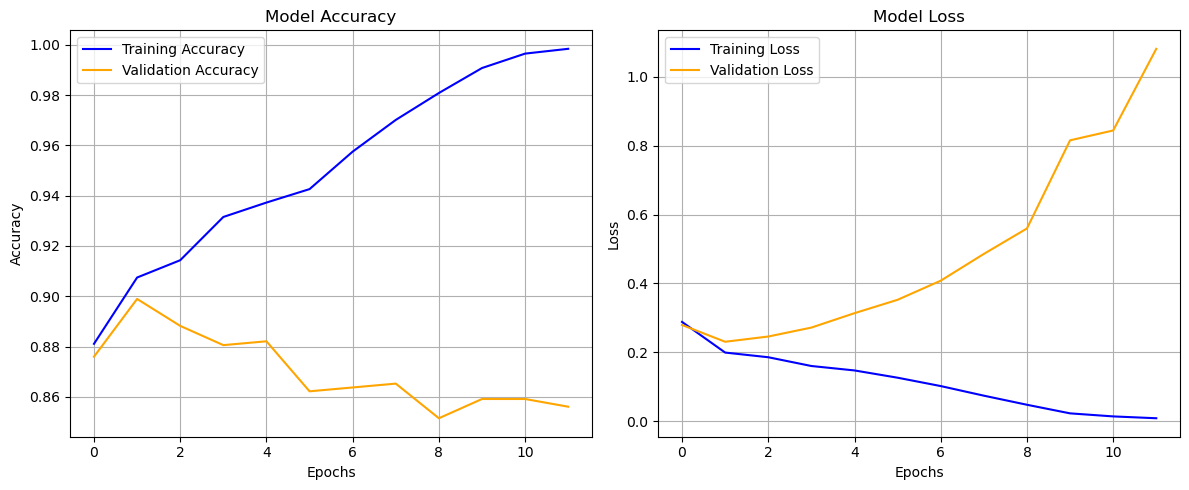

In [117]:
cnn2d_stock_models, cnn2d_stock_histories = [], []
for train_ds, val_ds in zip(train_dfs, val_dfs):
    cnn2d_stock_model = cnn2d_model()

    # Display the model architecture
    cnn2d_stock_model.summary()

    cnn2d_earlystopping = define_early_stopping()

    # Train the model on the training dataset and validate using val_ds for the specified number of epochs
    history = cnn2d_stock_model.fit(
        train_ds,                   # Training dataset
        validation_data=val_ds,     # Validation dataset
        epochs=EPOCHS,               # Number of training epochs
        callbacks=[cnn2d_earlystopping]
    )

    cnn2d_stock_models.append(cnn2d_stock_model)
    cnn2d_stock_histories.append(history)
    plot_training_history(history)

Evaluates CNN2d Model.

Test results for stock: BBAS3.SA
Model: <class 'keras.src.models.sequential.Sequential'>
Accuracy: 0.88
Precision: 0.88
Recall: 0.92
F1: 0.90
Confusion matrix:


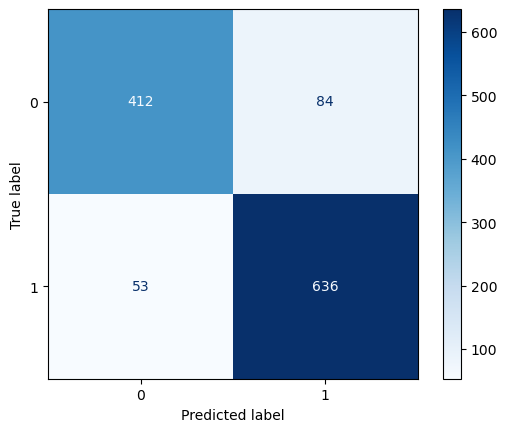

Backtesting for BBAS3.SA
Final portfolio value for BBAS3.SA: R$11669.61


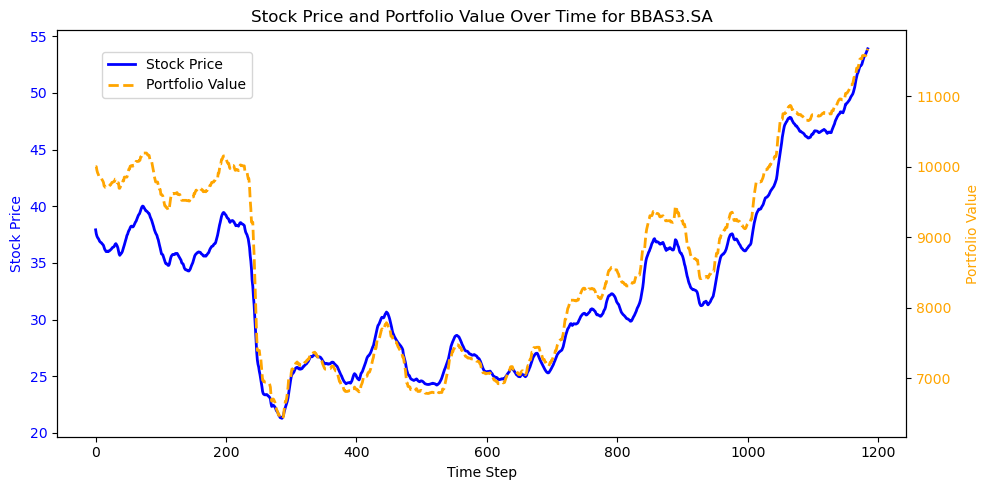


Test results for stock: CSNA3.SA
Model: <class 'keras.src.models.sequential.Sequential'>
Accuracy: 0.89
Precision: 0.95
Recall: 0.85
F1: 0.90
Confusion matrix:


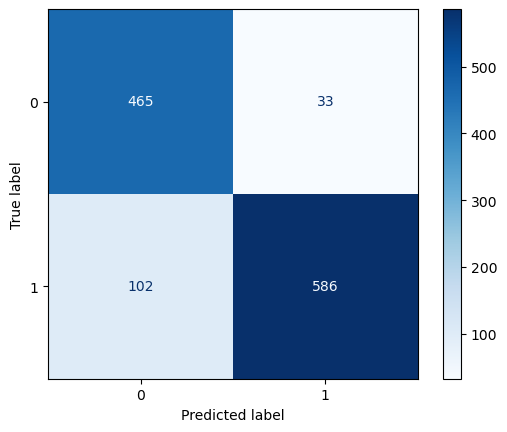

Backtesting for CSNA3.SA
Final portfolio value for CSNA3.SA: R$13436.11


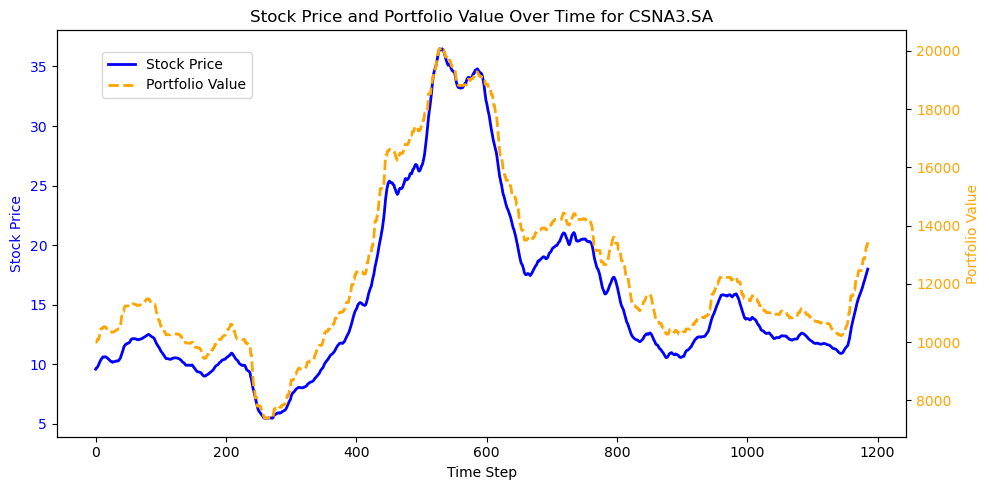


Test results for stock: PETR4.SA
Model: <class 'keras.src.models.sequential.Sequential'>
Accuracy: 0.86
Precision: 0.83
Recall: 0.90
F1: 0.86
Confusion matrix:


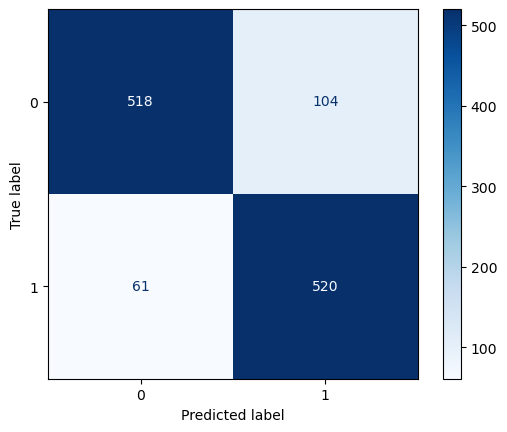

Backtesting for PETR4.SA
Final portfolio value for PETR4.SA: R$21443.63


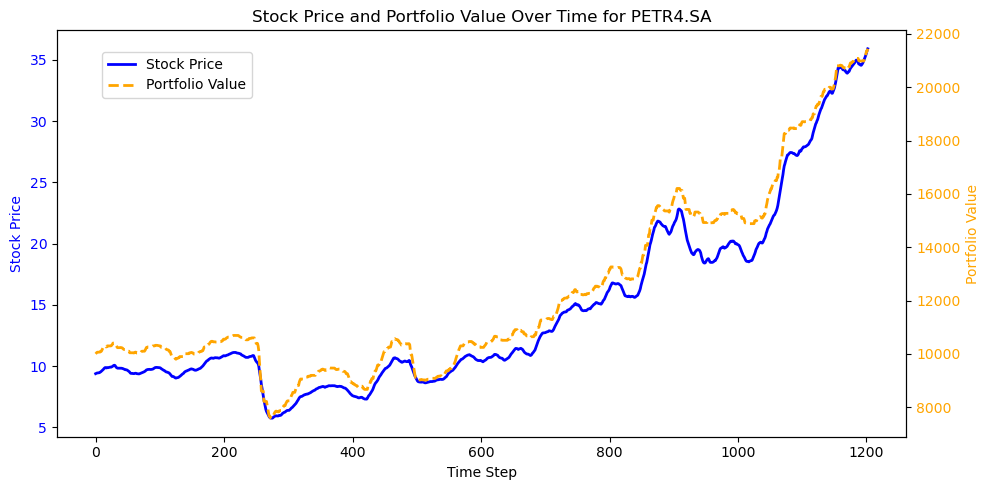


Test results for stock: VALE3.SA
Model: <class 'keras.src.models.sequential.Sequential'>
Accuracy: 0.80
Precision: 0.72
Recall: 0.98
F1: 0.83
Confusion matrix:


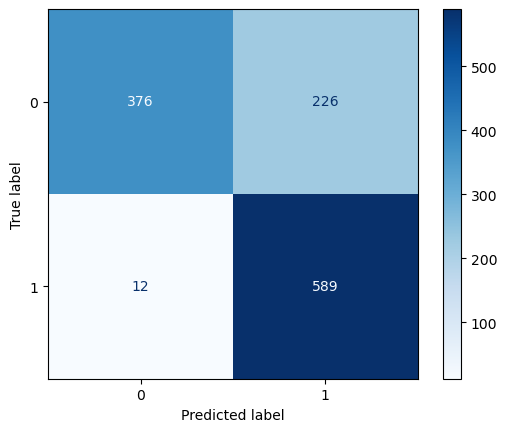

Backtesting for VALE3.SA
Final portfolio value for VALE3.SA: R$17737.00


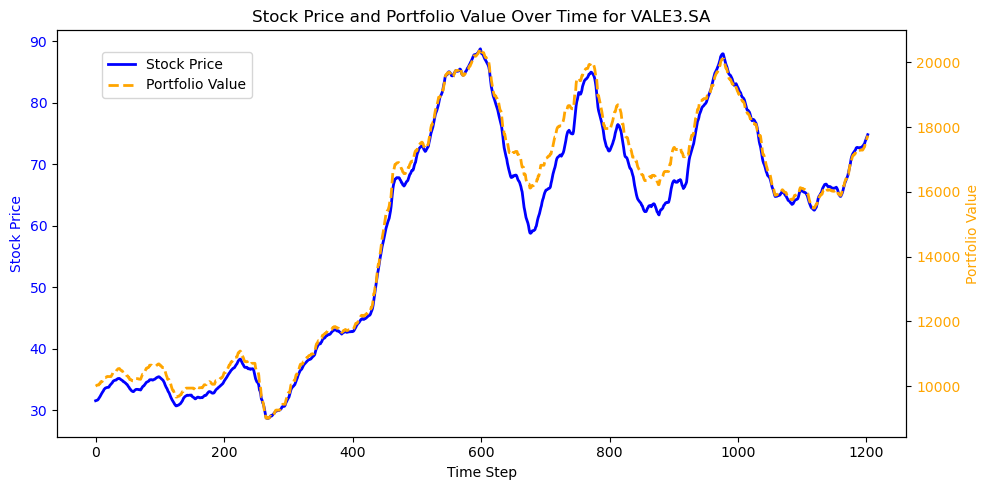

In [156]:
results(cnn2d_stock_models)

### ResNet50 Model.

In [12]:
def resnet50_model():
    # Load Pretrained ResNet50 Model
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

    # Freeze initial layers and fine-tune top layers
    for layer in base_model.layers[:-1]:  # Fine-tune only last 10 layers
        layer.trainable = False

    # Custom Classification Head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.4)(x)
    output = Dense(2, activation='softmax')(x)

    # Create Model
    model_resnet = Model(inputs=base_model.input, outputs=output)

    # Compile Model
    model_resnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_RESNET),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    
    return model_resnet

Train results for stock: BBAS3.SA
Epoch 1/200


I0000 00:00:1740662860.633363 2689688 service.cc:146] XLA service 0x73f1dc001d70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740662860.633385 2689688 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-02-27 10:27:40.696854: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-27 10:27:41.151393: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101
2025-02-27 10:27:41.590720: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5679', 168 bytes spill stores, 452 bytes spill loads



 12/119 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5455 - loss: 1.8400

I0000 00:00:1740662862.808881 2689688 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5483 - loss: 1.4295

2025-02-27 10:27:47.811568: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1710', 176 bytes spill stores, 176 bytes spill loads



119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.5488 - loss: 1.4259 - val_accuracy: 0.7994 - val_loss: 0.5228
Epoch 2/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7281 - loss: 0.5488 - val_accuracy: 0.7951 - val_loss: 0.4739
Epoch 3/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7670 - loss: 0.5058 - val_accuracy: 0.8237 - val_loss: 0.4597
Epoch 4/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7847 - loss: 0.4747 - val_accuracy: 0.8247 - val_loss: 0.4168
Epoch 5/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8074 - loss: 0.4404 - val_accuracy: 0.8289 - val_loss: 0.4308
Epoch 6/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8217 - loss: 0.4265 - val_accuracy: 0.8384 - val_loss: 0.3824
Epoch 7/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8242 - loss: 0.4088 - val_accuracy: 0.8279 - val_loss: 0.3649
Epoch 8/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8302 - loss: 0.3894 - val_accurac

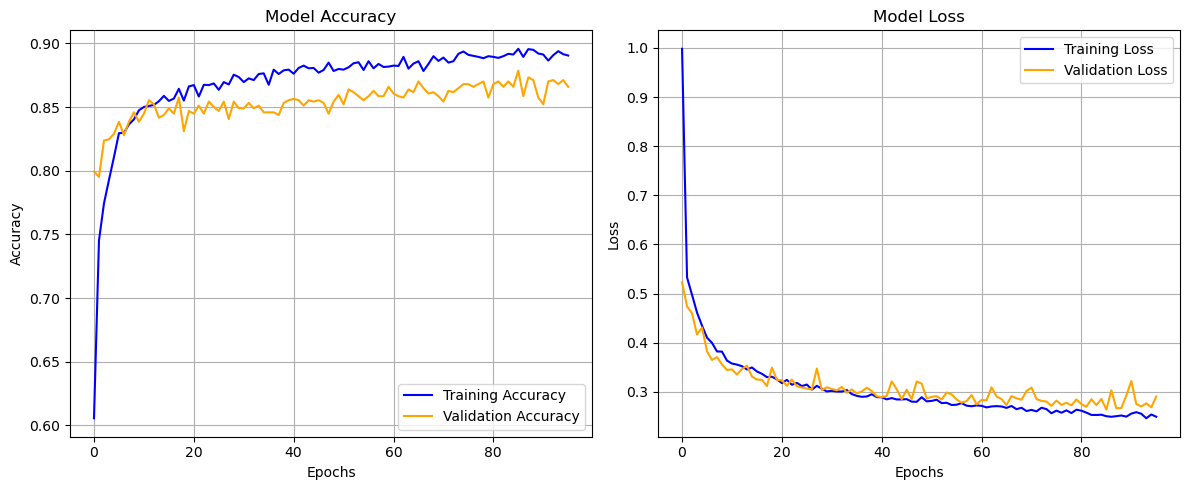

Train results for stock: CSNA3.SA
Epoch 1/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5361 - loss: 1.0155

2025-02-27 10:30:53.140594: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1710', 176 bytes spill stores, 176 bytes spill loads



119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.5366 - loss: 1.0137 - val_accuracy: 0.7584 - val_loss: 0.5776
Epoch 2/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7092 - loss: 0.5781 - val_accuracy: 0.8059 - val_loss: 0.4973
Epoch 3/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7561 - loss: 0.5133 - val_accuracy: 0.8143 - val_loss: 0.4470
Epoch 4/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8134 - loss: 0.4436 - val_accuracy: 0.8312 - val_loss: 0.4089
Epoch 5/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8171 - loss: 0.4221 - val_accuracy: 0.8249 - val_loss: 0.3948
Epoch 6/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8311 - loss: 0.3951 - val_accuracy: 0.8312 - val_loss: 0.3800
Epoch 7/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8445 - loss: 0.3873 - val_accuracy: 0.8407 - val_loss: 0.3598
Epoch 8/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8412 - loss: 0.3680 - val_accuracy

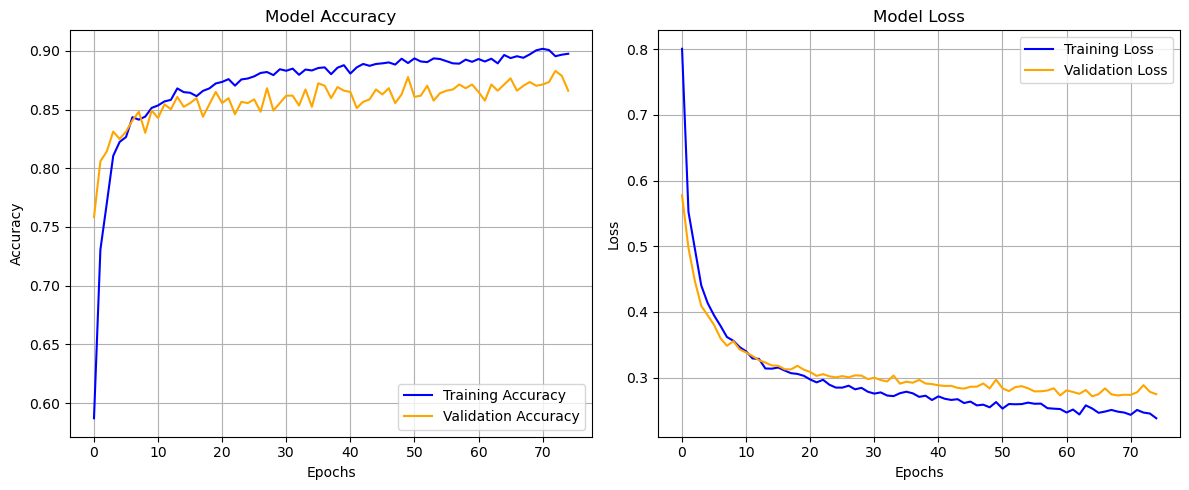

Train results for stock: PETR4.SA
Epoch 1/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.5203 - loss: 1.1806 - val_accuracy: 0.7097 - val_loss: 0.6329
Epoch 2/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6682 - loss: 0.6210 - val_accuracy: 0.8065 - val_loss: 0.5303
Epoch 3/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7390 - loss: 0.5639 - val_accuracy: 0.8075 - val_loss: 0.4894
Epoch 4/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7628 - loss: 0.5193 - val_accuracy: 0.8158 - val_loss: 0.4449
Epoch 5/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8008 - loss: 0.4650 - val_accuracy: 0.8470 - val_loss: 0.4127
Epoch 6/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8119 - loss: 0.4342 - val_accuracy: 0.8512 - val_loss: 0.3923
Epoch 7/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8192 - loss: 0.4204 - val_accuracy: 0.8460 - val_loss: 0.3709
Epoch 8/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - 

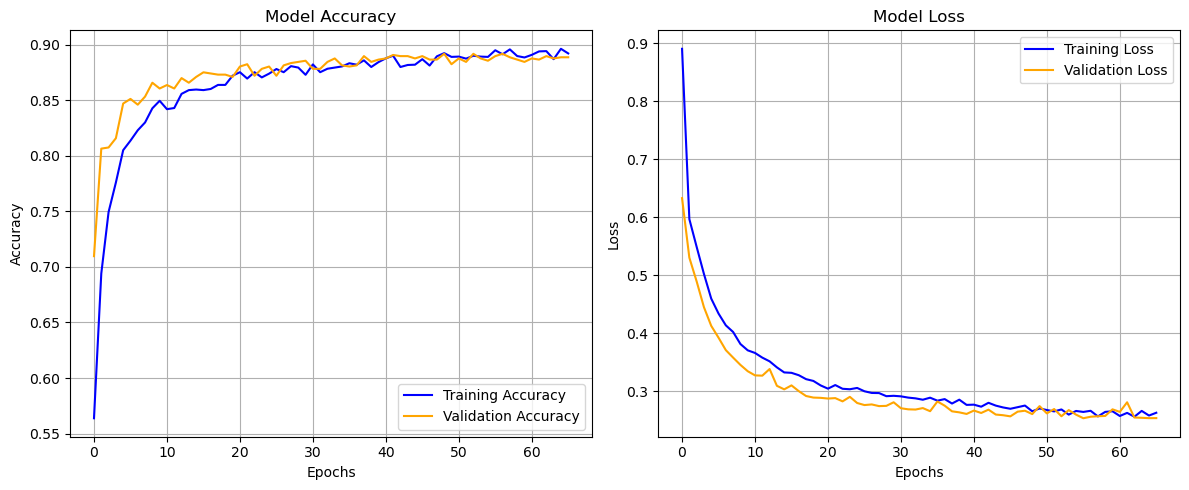

Train results for stock: VALE3.SA
Epoch 1/200
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5835 - loss: 1.6284

2025-02-27 10:35:29.724814: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5679', 176 bytes spill stores, 176 bytes spill loads



82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.5862 - loss: 1.6149 - val_accuracy: 0.8239 - val_loss: 0.5037
Epoch 2/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7903 - loss: 0.5801 - val_accuracy: 0.8239 - val_loss: 0.4120
Epoch 3/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8273 - loss: 0.4231 - val_accuracy: 0.8239 - val_loss: 0.3823
Epoch 4/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8434 - loss: 0.3857 - val_accuracy: 0.8224 - val_loss: 0.3674
Epoch 5/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8507 - loss: 0.3491 - val_accuracy: 0.8315 - val_loss: 0.3548
Epoch 6/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8572 - loss: 0.3442 - val_accuracy: 0.8300 - val_loss: 0.3407
Epoch 7/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8619 - loss: 0.3326 - val_accuracy: 0.8377 - val_loss: 0.3309
Epoch 8/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8648 - loss: 0.3230 - val_accuracy: 0.8270 - val_l

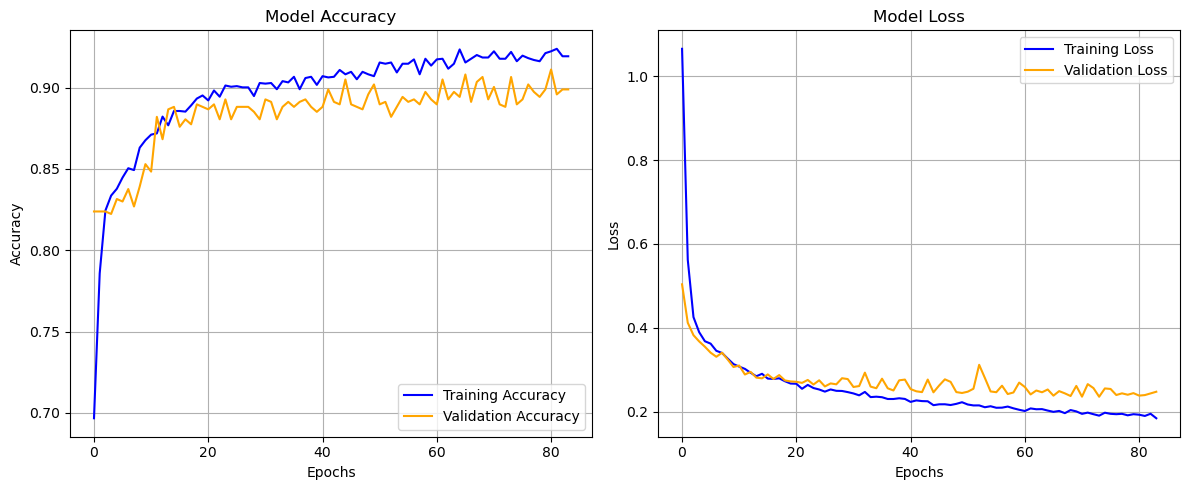

In [13]:
resnet50_stock_models, resnet50_stock_histories = [], []
for stock, train_ds, val_ds in zip(stocks, train_dfs, val_dfs):
    print(f"Train results for stock: {stock}")
    restnet50_stock_model = resnet50_model()    

    restnet50_earlystopping = define_early_stopping()

    history = restnet50_stock_model.fit(
        train_ds,
        epochs=EPOCHS,
        validation_data=val_ds,
        callbacks=[restnet50_earlystopping]
    )

    resnet50_stock_models.append(restnet50_stock_model)
    resnet50_stock_histories.append(history)
    plot_training_history(history)


Evaluates ResNet50 Model.

Test results for stock: BBAS3.SA
Model: <class 'keras.src.models.functional.Functional'>
Accuracy: 0.89
Precision: 0.91
Recall: 0.90
F1: 0.90
Confusion matrix:


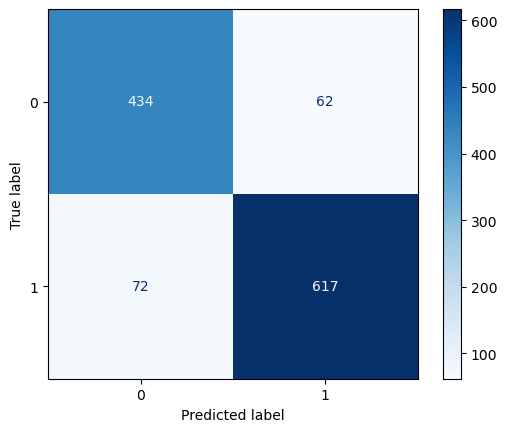

Backtesting for BBAS3.SA
Final portfolio value for BBAS3.SA: R$13445.63


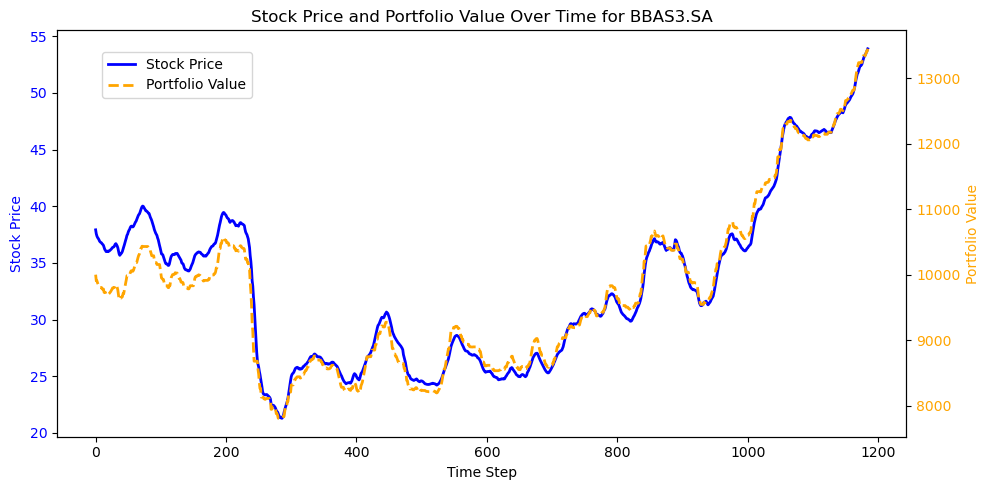


Test results for stock: CSNA3.SA
Model: <class 'keras.src.models.functional.Functional'>
Accuracy: 0.86
Precision: 0.90
Recall: 0.86
F1: 0.88
Confusion matrix:


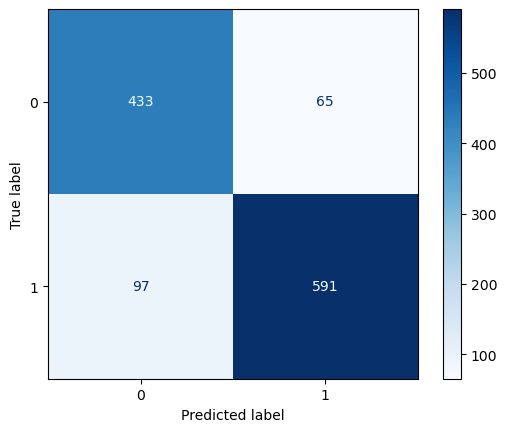

Backtesting for CSNA3.SA
Final portfolio value for CSNA3.SA: R$14276.67


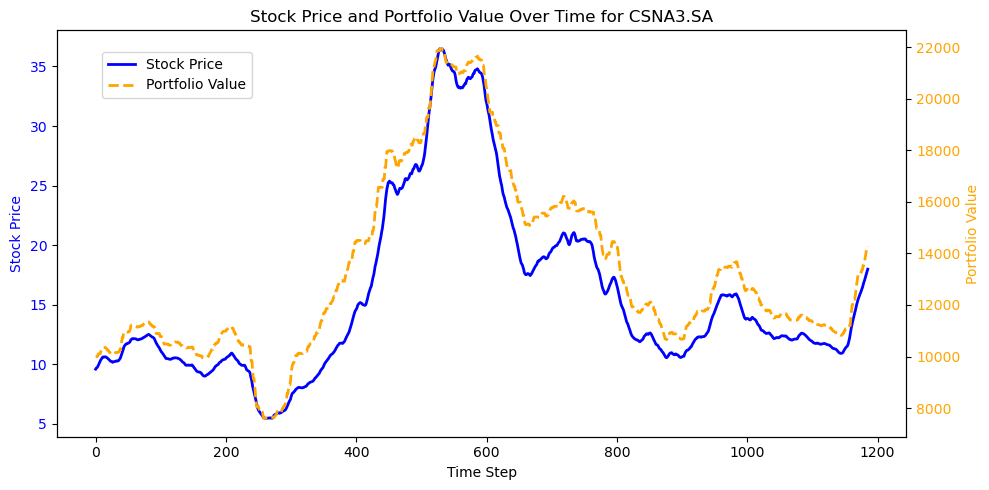


Test results for stock: PETR4.SA
Model: <class 'keras.src.models.functional.Functional'>
Accuracy: 0.84
Precision: 0.85
Recall: 0.83
F1: 0.84
Confusion matrix:


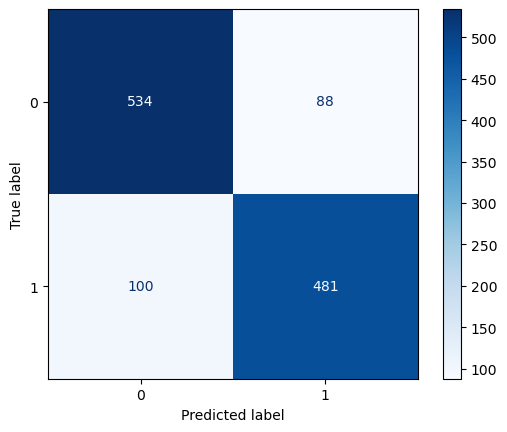

Backtesting for PETR4.SA
Final portfolio value for PETR4.SA: R$21780.42


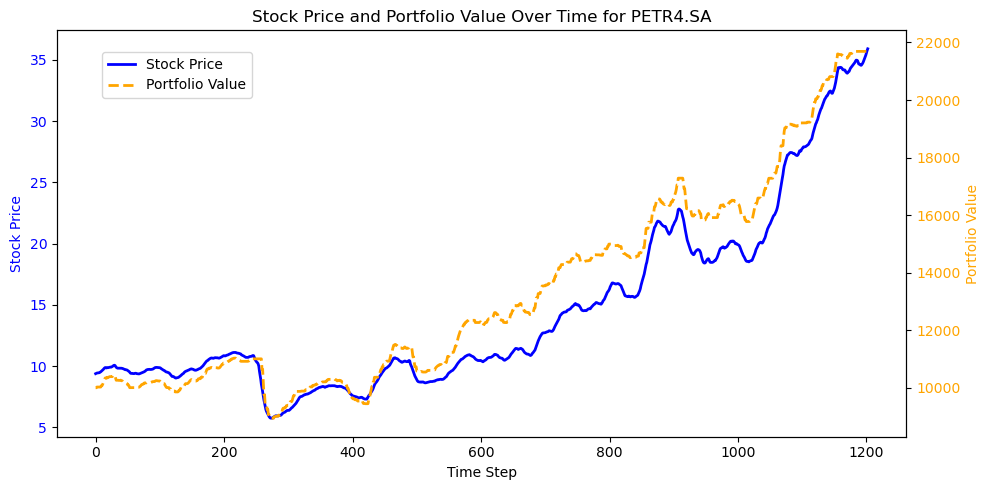


Test results for stock: VALE3.SA
Model: <class 'keras.src.models.functional.Functional'>
Accuracy: 0.76
Precision: 0.68
Recall: 0.98
F1: 0.80
Confusion matrix:


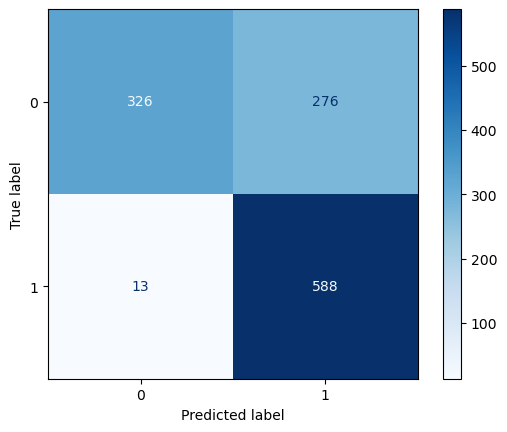

Backtesting for VALE3.SA
Final portfolio value for VALE3.SA: R$19697.92


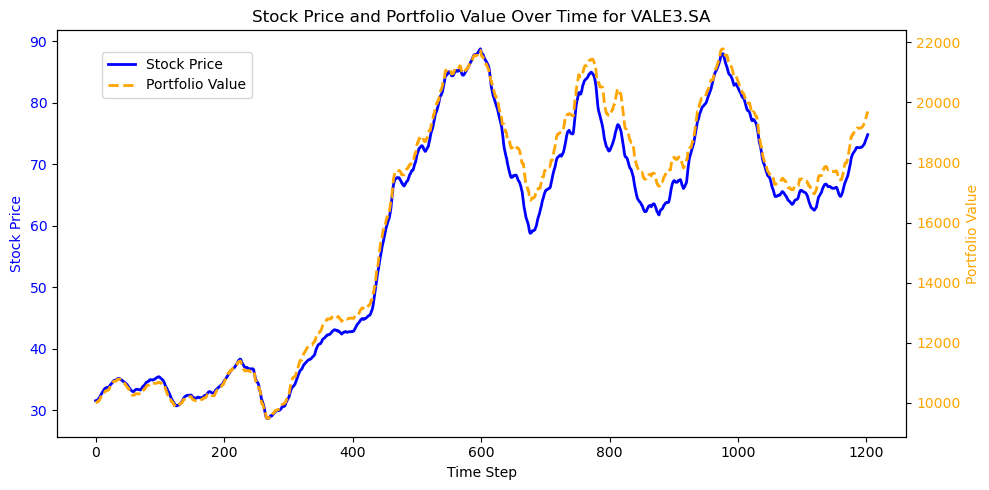

In [155]:
results(resnet50_stock_models)